In [1]:
import numpy as np
import matplotlib.pyplot as plt

# non-personalized movie recommendation system
- Here we assume that all users' rating criteria and movie features are **1**, that is, the latent factor d = 1
- In other words, we only computer the average rates of the movies 

In [ ]:


def load_data(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            user, movie, score = map(float, line.strip().split(','))
            data.append((int(user), int(movie), score))
    return data


def compute_movie_averages(data):
    movie_scores = {}
    movie_counts = {}
    for user, movie, score in data:
        if movie in movie_scores:
            movie_scores[movie] += score
            movie_counts[movie] += 1
        else:
            movie_scores[movie] = score
            movie_counts[movie] = 1
    movie_averages = {movie: movie_scores[movie] / movie_counts[movie] for movie in movie_scores}
    return movie_averages


def compute_mse(test_data, movie_averages):
    squared_errors = []
    for user, movie, score in test_data:
        predicted_score = movie_averages.get(movie, 0)  
        squared_errors.append((predicted_score - score) ** 2)
    return np.mean(squared_errors)


def compute_mae(test_data, movie_averages):
    absolute_errors = []
    for user, movie, score in test_data:
        predicted_score = movie_averages.get(movie, 0) 
        absolute_errors.append(abs(predicted_score - score))
    return np.mean(absolute_errors)


train_data = load_data('train.txt')
test_data = load_data('test.txt')

movie_averages = compute_movie_averages(train_data)

mse = compute_mse(test_data, movie_averages)
mae = compute_mae(test_data, movie_averages)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.5698466292119372
Mean Absolute Error (MAE): 0.6017598076709944


\newpage

# personalized movie recommendation system by SVD approximation
- By applying SVD, we can approximate the rating matrix
- All the unrated entries are filled by value **0**
- Try different number of latent factors d

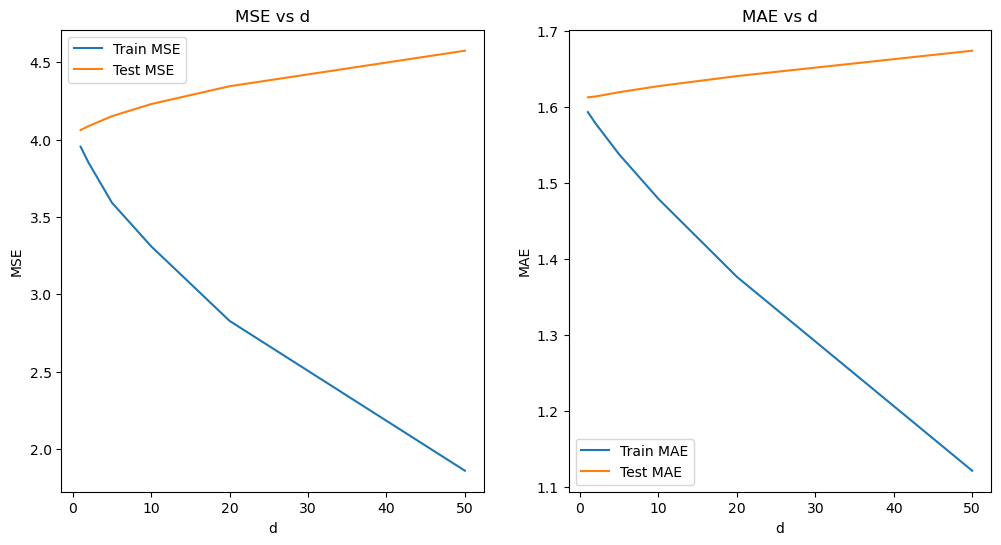

In [3]:
import matplotlib.pyplot as plt

def load_data(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            user, movie, score = map(float, line.strip().split(','))
            data.append((int(user), int(movie), score))
    return data

def build_rating_matrix(data, num_users, num_movies):
    R = np.zeros((num_users, num_movies))
    for user, movie, score in data:
        R[user-1, movie-1] = score  
    return R


def compute_mse(R_pred, R_true):
    mask = R_true != 0
    return np.mean((R_pred[mask] - R_true[mask]) ** 2)


def compute_mae(R_pred, R_true):
    mask = R_true != 0
    return np.mean(np.abs(R_pred[mask] - R_true[mask]))


train_data = load_data('train.txt')
test_data = load_data('test.txt')

num_users = 1000
num_movies = 500

R_train = build_rating_matrix(train_data, num_users, num_movies)
R_test = build_rating_matrix(test_data, num_users, num_movies)



d_values = [1,2,5,10,20,50]
train_mses = []
test_mses = []
train_maes = []
test_maes = []

for d in d_values:
    U, Sigma, VT = np.linalg.svd(R_train, full_matrices=False)
    U_d = U[:, :d]
    Sigma_d = np.diag(Sigma[:d])
    V_d = VT[:d, :]
    
    R_pred_train = U_d @ Sigma_d @ V_d
    
    R_pred_test = U_d @ Sigma_d @ V_d
    
    train_mse = compute_mse(R_pred_train, R_train)
    test_mse = compute_mse(R_pred_test, R_test)
    train_mae = compute_mae(R_pred_train, R_train)
    test_mae = compute_mae(R_pred_test, R_test)
    
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    train_maes.append(train_mae)
    test_maes.append(test_mae)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(d_values, train_mses, label='Train MSE')
plt.plot(d_values, test_mses, label='Test MSE')
plt.xlabel('d')
plt.ylabel('MSE')
plt.title('MSE vs d')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_values, train_maes, label='Train MAE')
plt.plot(d_values, test_maes, label='Test MAE')
plt.xlabel('d')
plt.ylabel('MAE')
plt.title('MAE vs d')
plt.legend()

plt.show()

\newpage

# personalized movie recommendation system by ALS algorithms
- filling unrated entries might not be a proper approach
- instead, we use alternating minimization scheme to perform matrix completion 

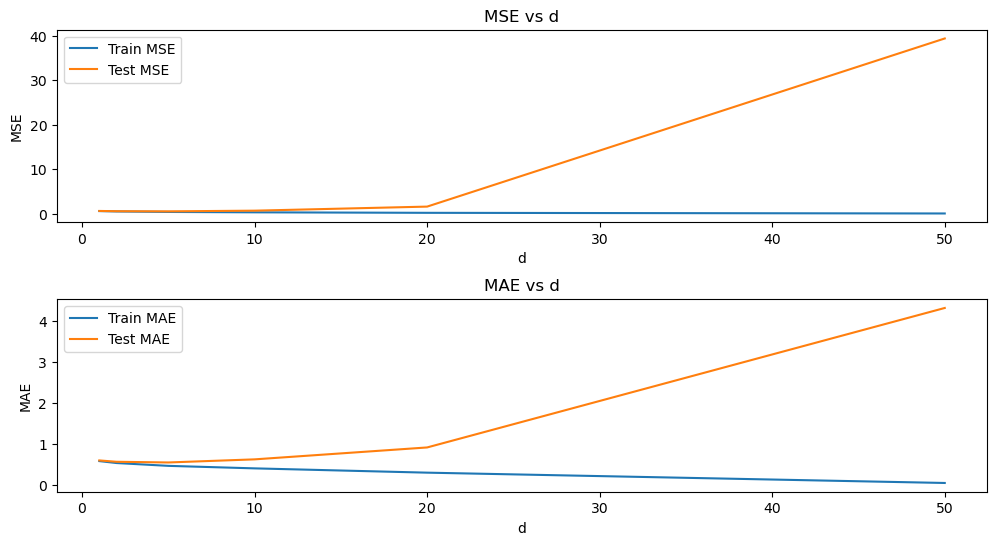

In [8]:
def load_data(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            user, movie, score = map(float, line.strip().split(','))
            data.append((int(user), int(movie), score))
    return data

def build_rating_matrix(data, num_users, num_movies):
    R = np.zeros((num_users, num_movies))
    for user, movie, score in data:
        R[user-1, movie-1] = score  
    return R

def compute_mse(R_pred, R_true):
    mask = R_true != 0
    return np.mean((R_pred[mask] - R_true[mask]) ** 2)

def compute_mae(R_pred, R_true):
    mask = R_true != 0
    return np.mean(np.abs(R_pred[mask] - R_true[mask]))

def alternating_minimization(R, d, lambda_reg, num_iterations=10):
    num_users, num_movies = R.shape
    U = np.random.randn(num_users, d)
    V = np.random.randn(num_movies, d)
    
    for iteration in range(num_iterations):
        for i in range(num_users):
            rated_movies = np.where(R[i, :] != 0)[0]
            if len(rated_movies) > 0:
                V_rated = V[rated_movies, :]
                R_rated = R[i, rated_movies]
                U[i, :] = np.linalg.lstsq(V_rated.T @ V_rated + lambda_reg * np.eye(d), V_rated.T @ R_rated, rcond=None)[0]
        
        for j in range(num_movies):
            rated_users = np.where(R[:, j] != 0)[0]
            if len(rated_users) > 0:
                U_rated = U[rated_users, :]
                R_rated = R[rated_users, j]
                V[j, :] = np.linalg.lstsq(U_rated.T @ U_rated + lambda_reg * np.eye(d), U_rated.T @ R_rated, rcond=None)[0]
    
    return U, V

train_data = load_data('train.txt')
test_data = load_data('test.txt')

num_users = 1000
num_movies = 500

R_train = build_rating_matrix(train_data, num_users, num_movies)
R_test = build_rating_matrix(test_data, num_users, num_movies)


d_values = [1,2,5,10,20,50]
lambda_reg = 1e-3
train_mses = []
test_mses = []
train_maes = []
test_maes = []

for d in d_values:
    U, V = alternating_minimization(R_train, d, lambda_reg)
    
    R_pred_train = U @ V.T
    R_pred_test = U @ V.T
    
    train_mse = compute_mse(R_pred_train, R_train)
    test_mse = compute_mse(R_pred_test, R_test)
    train_mae = compute_mae(R_pred_train, R_train)
    test_mae = compute_mae(R_pred_test, R_test)
    
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    train_maes.append(train_mae)
    test_maes.append(test_mae)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(d_values, train_mses, label='Train MSE')
plt.plot(d_values, test_mses, label='Test MSE')
plt.xlabel('d')
plt.ylabel('MSE')
plt.title('MSE vs d')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(d_values, train_maes, label='Train MAE')
plt.plot(d_values, test_maes, label='Test MAE')
plt.xlabel('d')
plt.ylabel('MAE')
plt.title('MAE vs d')
plt.legend()

plt.subplots_adjust(hspace=0.4)



plt.show()

## interpretation
- we can note that the error values become larger when d > 20, which indicate an overfitting